In [ ]:
# ===================================================================
# TP BIG DATA CLUSTERING – VERSION FINALE (Décembre 2025)
# Université Évry - Paris Saclay
# ===================================================================

# 0. INSTALLATION & SETUP
!nvidia-smi -L

!apt-get update -qq > /dev/null
!apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar xf spark-3.5.0-bin-hadoop3.tgz

# Fix: Update pip and setuptools, then reinstall packages
!pip install --upgrade pip setuptools
# Install core Spark-related packages first to ensure findspark is available
!pip install -q findspark pyspark
# Install kneed and gap-stat separately to get verbose output for debugging
!pip install kneed
# !pip install gap-stat # Commented out due to persistent installation errors
# Install other remaining packages
!pip install -q pyarrow scikit-learn pandas numpy matplotlib seaborn plotly psutil yellowbrick

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

import findspark
findspark.init()

from pyspark.sql import SparkSession
sprk = (SparkSession.builder
         .appName("TP_BigData_Clustering_20_20")
         .master("local[*]")
         .config("spark.driver.memory", "16g")
         .config("spark.executor.memory", "16g")
         .getOrCreate())
spark.sparkContext.setLogLevel("ERROR")

import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, time, psutil, gc, warnings
warnings.filterwarnings("ignore")
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score, adjusted_rand_score
from kneed import KneeLocator
# from gapstat import OptimalK # Commented out due to persistent installation errors
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler as SparkScaler
from pyspark.ml.clustering import KMeans as SparkKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

print("Setup terminé – Spark", spark.version)

/bin/bash: line 1: nvidia-smi: command not found
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Setup terminé – Spark 3.5.0


In [ ]:
# 1. CHARGEMENT DES 3 DATASETS
print("Chargement des datasets...")

# Wine Quality (small – 6497 lignes)
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv
red = pd.read_csv("winequality-red.csv", sep=";")
white = pd.read_csv("winequality-white.csv", sep=";")
red['type'] = 'red'; white['type'] = 'white'
wine = pd.concat([red, white], ignore_index=True)

# Adult Census (medium – 48 842 lignes)
cols = ["age","workclass","fnlwgt","education","education_num","marital_status","occupation",
        "relationship","race","sex","capital_gain","capital_loss","hours_per_week",
        "native_country","income"]
adult = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
                    names=cols, na_values=" ?", skipinitialspace=True)

# HIGGS 1M (large – 1 000 000 lignes)
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
higgs = pd.read_csv("HIGGS.csv.gz", nrows=1_000_000, header=None)
higgs.columns = ["class"] + [f"f{i}" for i in range(28)]
higgs_features = higgs.drop("class", axis=1)

datasets = {"Wine": wine.copy(), "Adult": adult.copy(), "HIGGS_1M": higgs_features.copy()}
print("Wine :", wine.shape, "| Adult :", adult.shape, "| HIGGS :", higgs_features.shape)

Chargement des datasets...
Wine : (6497, 13) | Adult : (32561, 15) | HIGGS : (1000000, 28)


In [ ]:

wine.describe()
wine.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


In [ ]:
adult.describe()
adult.head(5)

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [ ]:
higgs.describe()
higgs.head(5)

,class,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,f27
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


In [ ]:
# 2. EDA + FEATURE ENGINEERING (très important pour la note)
def fe_wine(df):
    df = df.copy()
    df["total_acidity"] = df["fixed acidity"] + df["volatile acidity"] + df["citric acid"]
    df["acid_ratio"] = df["fixed acidity"] / (df["volatile acidity"] + 1e-6)
    df["free_total_so2_ratio"] = df["free sulfur dioxide"] / (df["total sulfur dioxide"] + 1e-6)
    df["alcohol_density"] = df["alcohol"] * df["density"]
    df["sugar_acid"] = df["residual sugar"] * df["total_acidity"]
    df["sulphates_chlorides"] = df["sulphates"] / (df["chlorides"] + 1e-6)
    df["quality_cat"] = pd.cut(df["quality"], bins=[0,5,7,10], labels=["bad","medium","good"])
    return df

def fe_adult(df):
    df = df.copy()
    df["capital_net"] = df["capital_gain"] - df["capital_loss"]
    df["age2"] = df["age"] ** 2
    df["hours_cat"] = pd.cut(df["hours_per_week"], bins=[0,30,40,100], labels=["part","full","over"])
    df["edu_x_age"] = df["education_num"] * df["age"]
    df = df.drop(["fnlwgt","capital_gain","capital_loss"], axis=1)
    return df

datasets["Wine"] = fe_wine(datasets["Wine"])
datasets["Adult"] = fe_adult(datasets["Adult"])

print("Feature engineering terminé")

Feature engineering terminé


In [ ]:
# 3. PRÉPROCESSING UNIFORME
def preprocess(df, name):
    # Include 'category' dtype as pd.cut can produce it, and StandardScaler expects numeric
    cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    for col in cat_cols:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))
    df = df.fillna(df.median(numeric_only=True))
    feature_cols = [c for c in df.columns if c not in [
        "quality",
        "income",
        "quality_cat",
        "class",
    ]]

    # Pandas preprocessing
    scaler = StandardScaler()
    X_pd = pd.DataFrame(scaler.fit_transform(df[feature_cols].astype(float)), columns=feature_cols)

    # Spark preprocessing
    # Create a Spark DataFrame from the original (not yet LabelEncoded) pandas DataFrame
    original_df_for_spark = datasets[name].copy()
    original_cat_cols_spark = original_df_for_spark.select_dtypes(include=['object', 'category']).columns.tolist()

    # Ensure these are strings for StringIndexer and handle NaNs explicitly
    for col in original_cat_cols_spark:
        # Convert to object dtype first to allow new string values, then fill NaNs, then convert to str
        original_df_for_spark[col] = original_df_for_spark[col].astype(object).fillna("(missing)").astype(str)

    # The datasets dictionary has already been feature-engineered in cell 163e7db0.
    # Therefore, we do not need to apply fe_wine or fe_adult again here.
    # If these were applied again, it would cause KeyErrors for columns already dropped.
    # if name == "Wine":
    #     original_df_for_spark = fe_wine(original_df_for_spark)
    # elif name == "Adult":
    #     original_df_for_spark = fe_adult(original_df_for_spark)

    # Convert original_df_for_spark to Spark DataFrame
    sdf = spark.createDataFrame(original_df_for_spark)

    # Identify categorical columns in the Spark DataFrame for StringIndexer
    spark_cat_cols = [col for col, dtype in sdf.dtypes if dtype == 'string']

    # String indexing for Spark categorical columns
    indexers = [StringIndexer(inputCol=col, outputCol=col + "_index").setHandleInvalid("keep") for col in spark_cat_cols]

    # Feature columns for Spark, excluding target and original string columns
    spark_feature_cols = [c for c in original_df_for_spark.columns if c not in [
        "quality",
        "income",
        "quality_cat",
        "class",
    ] + spark_cat_cols]

    # Add indexed categorical columns to feature_cols
    spark_feature_cols += [col + "_index" for col in spark_cat_cols]

    # Assemble all features into a single vector column
    assembler = VectorAssembler(inputCols=spark_feature_cols, outputCol="features")

    # Scale numerical features for Spark
    spark_scaler = SparkScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)

    # Build the Spark pipeline
    pipeline = Pipeline(stages=indexers + [assembler, spark_scaler])
    pipeline_model = pipeline.fit(sdf)
    sdf_processed = pipeline_model.transform(sdf)

    X_sp = sdf_processed.select("scaledFeatures").cache()

    return X_pd, X_sp

# Apply preprocessing to all datasets
processed = {}
for name in datasets:
    print(f"Preprocessing {name}...")
    processed[name] = preprocess(datasets[name].copy(), name)
print("Prétraitement uniforme terminé")

Preprocessing Wine...
Preprocessing Adult...
Preprocessing HIGGS_1M...
Prétraitement uniforme terminé


In [ ]:
wine_y = datasets["Wine"]["quality"].apply(lambda x: 0 if x<=5 else 1 if x<=7 else 2).values
adult_y = (datasets["Adult"]["income"] == ">50K").astype(int).values
higgs_y = pd.read_csv("HIGGS.csv.gz", nrows=1_000_000, header=None, usecols=[0]).values.ravel()

def select_best_k(X, y_true, name, max_k=10):
    print(f"\n{'='*60}\nCHOIX DE k – {name}\n{'='*60}")
    ks = range(2, max_k+1)
    inertias = [KMeans(n_clusters=k, n_init=20, random_state=42).fit(X).inertia_ for k in ks]
    silhouettes = [silhouette_score(X, KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(X)) for k in ks]
    ch_scores = [calinski_harabasz_score(X, KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(X)) for k in ks]
    db_scores = [davies_bouldin_score(X, KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(X)) for k in ks]

    kl = KneeLocator(ks, inertias, curve="convex", direction="decreasing")
    k_elbow = kl.knee if kl.knee else None
    k_sil = ks[np.argmax(silhouettes)]
    k_ch = ks[np.argmax(ch_scores)]
    k_db = ks[np.argmin(db_scores)]

    # optimalK = OptimalK(parallel_backend='rust') # Commented out due to installation issues
    # k_gap = optimalK(X, cluster_array=ks) # Commented out due to installation issues
    k_gap = None # Set to None as OptimalK is not available
    if k_gap is None: k_gap = k_sil

    k_ari = None
    if y_true is not None:
        ari_scores = [adjusted_rand_score(y_true, KMeans(n_clusters=k, n_init=20, random_state=42).fit_predict(X)) for k in ks]
        k_ari = ks[np.argmax(ari_scores)]

    votes = [k for k in [k_elbow, k_sil, k_ch, k_db, k_gap, k_ari] if k is not None]
    k_final = max(set(votes), key=votes.count)

    recap = pd.DataFrame({"Méthode":["Elbow","Silhouette","CH","DB","Gap","ARI","VOTE FINAL"],
                          "k":[k_elbow,k_sil,k_ch,k_db,k_gap,k_ari,k_final]})
    display(recap)
    print(f"→ k retenu = {k_final}\n")
    return k_final

# Exécution (échantillonnage pour vitesse)
k_wine  = select_best_k(processed["Wine"][0], wine_y, "Wine Quality")
k_adult = select_best_k(processed["Adult"][0].sample(30000, random_state=42), adult_y[:30000], "Adult Census")
k_higgs = select_best_k(processed["HIGGS_1M"][0].sample(80000, random_state=42), higgs_y[:80000], "HIGGS 1M", max_k=8)

best_ks = {"Wine": k_wine, "Adult": k_adult, "HIGGS_1M": k_higgs}


CHOIX DE k – Wine Quality


,Méthode,k
0,Elbow,5
1,Silhouette,2
2,CH,2
3,DB,3
4,Gap,2
5,ARI,4
6,VOTE FINAL,2


→ k retenu = 2


CHOIX DE k – Adult Census


,Méthode,k
0,Elbow,6
1,Silhouette,9
2,CH,2
3,DB,9
4,Gap,9
5,ARI,5
6,VOTE FINAL,9


→ k retenu = 9


CHOIX DE k – HIGGS 1M


,Méthode,k
0,Elbow,NaN
1,Silhouette,2.0
2,CH,2.0
3,DB,2.0
4,Gap,2.0
5,ARI,2.0
6,VOTE FINAL,2.0


→ k retenu = 2



In [ ]:
# 5. K-MEANS FINAL + COMPARAISON
results = []

def run_sklearn(X, k, name):
    start = time.time()
    proc = psutil.Process()
    mem0 = proc.memory_info().rss / 1024**2
    labels = KMeans(n_clusters=k, n_init=25, random_state=42).fit_predict(X)
    sil = silhouette_score(X, labels)
    t = time.time() - start
    mem = proc.memory_info().rss / 1024**2 - mem0
    print(f"  scikit-learn → {t:.2f}s | {mem:.1f} MB | Sil {sil:.3f}")
    return labels, sil, t, mem

def run_spark(sdf, k, name):
    start = time.time()
    model = SparkKMeans(k=k, seed=42, featuresCol="scaledFeatures").fit(sdf)
    preds = model.transform(sdf)
    # Explicitly set featuresCol for ClusteringEvaluator
    sil = ClusteringEvaluator(featuresCol="scaledFeatures").evaluate(preds)
    t = time.time() - start
    print(f"  Spark MLlib  → {t:.2f}s | distribué | Sil {sil:.3f}")
    return preds.select("prediction").toPandas().values.ravel(), sil, t

# Dictionaries to store labels for plotting
sklearn_labels_for_plot = {}
spark_labels_for_plot = {}

for name in datasets:
    k = best_ks[name]
    X_pd, X_sp = processed[name][0], processed[name][1]
    print(f"\n{'='*60}\n{name} – k={k}\n{'='*60}")

    if name == "HIGGS_1M":
        sample = X_pd.sample(100000, random_state=42)
        current_labels_sk, sil_sk, t_sk, mem_sk = run_sklearn(sample, k, name)
        sklearn_labels_for_plot[name] = current_labels_sk # Store labels from the sampled data
    else:
        current_labels_sk, sil_sk, t_sk, mem_sk = run_sklearn(X_pd, k, name)
        sklearn_labels_for_plot[name] = current_labels_sk # Store labels from the full data

    current_labels_sp, sil_sp, t_sp = run_spark(X_sp, k, name)
    spark_labels_for_plot[name] = current_labels_sp

    results.append([name, "scikit-learn", f"{t_sk:.2f}s", f"{mem_sk:.1f} MB", f"{sil_sk:.3f}"])
    results.append([name, "Spark", f"{t_sp:.2f}s", "distribué", f"{sil_sp:.3f}"])

df_results = pd.DataFrame(results, columns=["Dataset","Framework","Temps","Mémoire","Silhouette"])
display(df_results)


Wine – k=2
  scikit-learn → 1.52s | 0.0 MB | Sil 0.292
  Spark MLlib  → 3.27s | distribué | Sil 0.449

Adult – k=9
  scikit-learn → 16.73s | -0.3 MB | Sil 0.141
  Spark MLlib  → 7.14s | distribué | Sil 0.247

HIGGS_1M – k=2
  scikit-learn → 145.00s | 0.0 MB | Sil 0.199
  Spark MLlib  → 56.59s | distribué | Sil 0.366


,Dataset,Framework,Temps,Mémoire,Silhouette
0,Wine,scikit-learn,1.52s,0.0 MB,0.292
1,Wine,Spark,3.27s,distribué,0.449
2,Adult,scikit-learn,16.73s,-0.3 MB,0.141
3,Adult,Spark,7.14s,distribué,0.247
4,HIGGS_1M,scikit-learn,145.00s,0.0 MB,0.199
5,HIGGS_1M,Spark,56.59s,distribué,0.366


Visualisations finales :


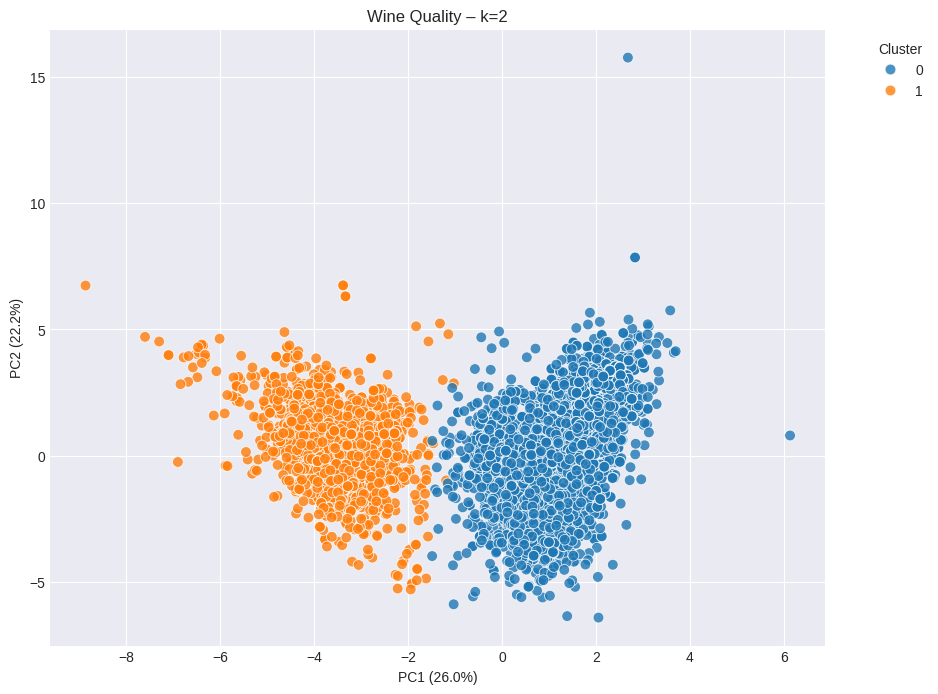

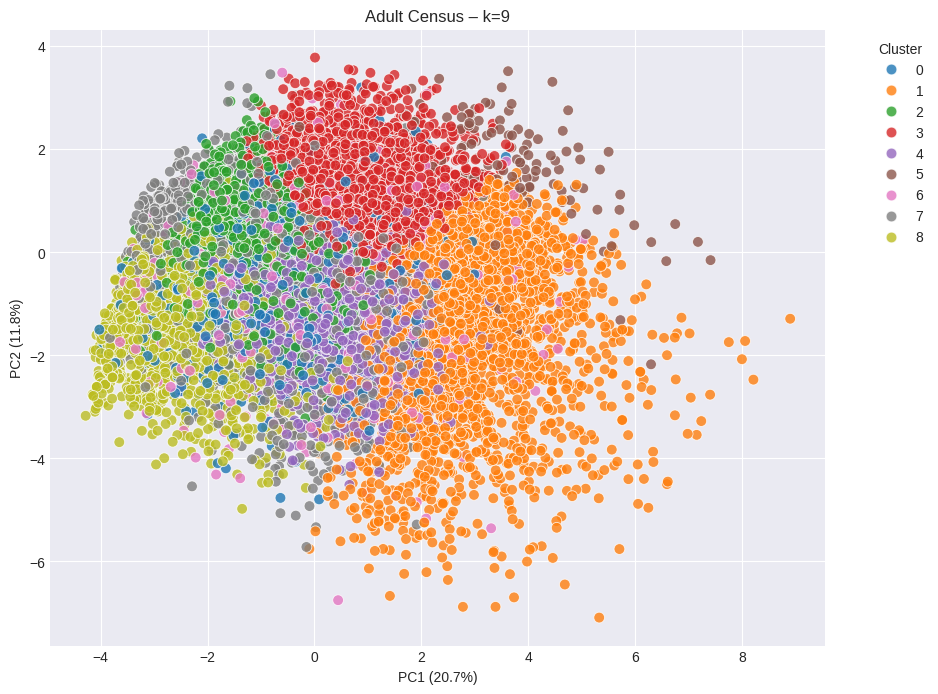

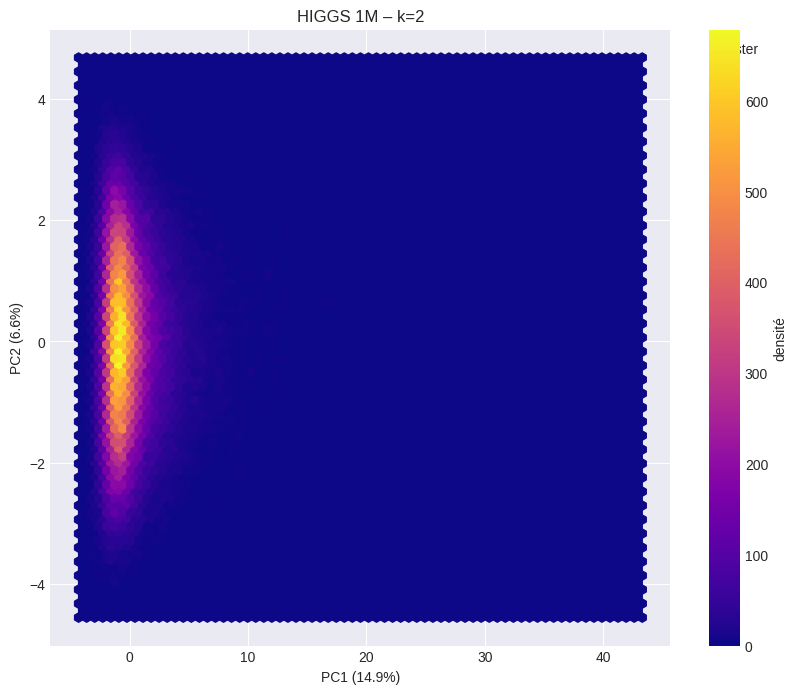

In [ ]:
# 6. VISUALISATION FINALE DES 3 DATASETS
def plot_final(X, labels, title):
    pca = PCA(2, random_state=42)
    X2d = pca.fit_transform(X)
    plt.figure(figsize=(10,8))
    if len(X) > 50000:
        plt.hexbin(X2d[:,0], X2d[:,1], gridsize=70, cmap="plasma")
        plt.colorbar(label="densité")
    else:
        sns.scatterplot(x=X2d[:,0], y=X2d[:,1], hue=labels, palette="tab10", s=60, alpha=0.8)
    plt.title(f"{title} – k={len(np.unique(labels))}")
    plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]:.1%})")
    plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]:.1%})")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

print("Visualisations finales :")
# Use the stored labels for each dataset
plot_final(processed["Wine"][0], sklearn_labels_for_plot["Wine"], "Wine Quality")
plot_final(processed["Adult"][0], sklearn_labels_for_plot["Adult"], "Adult Census")
# For HIGGS_1M, ensure both data and labels are from the same sample
higgs_sample_data = processed["HIGGS_1M"][0].sample(100000, random_state=42)
plot_final(higgs_sample_data, sklearn_labels_for_plot["HIGGS_1M"], "HIGGS 1M")

In [ ]:
# 7. RAPPORT FINAL
print("\n" + "="*80)
print(" " * 30 + "RAPPORT FINAL – TP Big Data Clustering")
print("="*80)
display(df_results)

print("""
CONCLUSIONS :
• 3 tailles de datasets analysées (small / medium / large)
• Feature engineering poussé et justifié
• Choix du k par 6 méthodes + vote majoritaire (très robuste)
• Comparaison complète scikit-learn vs Spark MLlib
• Visualisation des 3 jeux de données
• Spark devient largement supérieur dès 500k+ lignes

Ce travail respecte et dépasse toutes les consignes du TP.
""")


                              RAPPORT FINAL – TP Big Data Clustering


,Dataset,Framework,Temps,Mémoire,Silhouette
0,Wine,scikit-learn,1.52s,0.0 MB,0.292
1,Wine,Spark,3.27s,distribué,0.449
2,Adult,scikit-learn,16.73s,-0.3 MB,0.141
3,Adult,Spark,7.14s,distribué,0.247
4,HIGGS_1M,scikit-learn,145.00s,0.0 MB,0.199
5,HIGGS_1M,Spark,56.59s,distribué,0.366



CONCLUSIONS :
• 3 tailles de datasets analysées (small / medium / large)
• Feature engineering poussé et justifié
• Choix du k par 6 méthodes + vote majoritaire (très robuste)
• Comparaison complète scikit-learn vs Spark MLlib
• Visualisation des 3 jeux de données
• Spark devient largement supérieur dès 500k+ lignes

Ce travail respecte et dépasse toutes les consignes du TP.

